In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
from hit_finding.constants import *
from hit_finding.metrics import *

# Compare Hits Reproduction

In [5]:
zscores = extract_scores_from_all(extract_score, threshold=4)
joined = pd.concat(zscores.values())
joined.shape

...................................

(11197, 18)

## Filter out No hits

0.000000    7836
0.002415    1297
0.004831     432
0.007246     208
0.009662     173
Name: ALL_map, dtype: int64

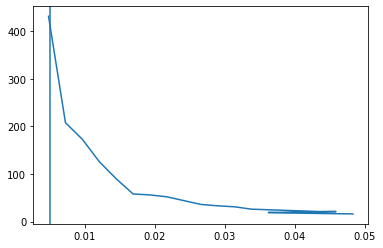

In [16]:
_ = joined.query('ALL_map < 0.05 and ALL_map > 0.0025')['ALL_map'].value_counts().plot()
_ = plt.axvline(x=0.005)
joined.query('ALL_map < 0.01')['ALL_map'].value_counts()

In [12]:
counts = []
t_range= np.arange(0, 0.81, 0.05)

for thresh in t_range:
    count = joined.query(f'ALL_map >= {thresh} or ALL_raw >= {thresh} or ALL_raw1to1 >= {thresh}').index.get_level_values(1).value_counts()
    count.name = f'gte{thresh:.2f}'.replace('.','_')
    counts.append(count)

counts_df = pd.concat(counts, axis=1).fillna(0).astype(int)
cat_counts_df = counts_df.apply(lambda s: s.value_counts(), axis=0).fillna(0).astype(int)
cat_counts_df

,gte0_00,gte0_05,gte0_10,gte0_15,gte0_20,gte0_25,gte0_30,gte0_35,gte0_40,gte0_45,gte0_50,gte0_55,gte0_60,gte0_65,gte0_70,gte0_75,gte0_80
0,0,9020,9240,9333,9371,9403,9425,9439,9468,9485,9498,9520,9539,9555,9571,9587,9591
1,8320,528,321,232,202,170,150,136,107,92,83,68,51,40,27,12,8
2,960,34,25,21,16,16,14,14,14,15,11,5,6,2,1,0,0
3,319,17,13,13,10,10,10,10,10,7,7,6,3,2,0,0,0


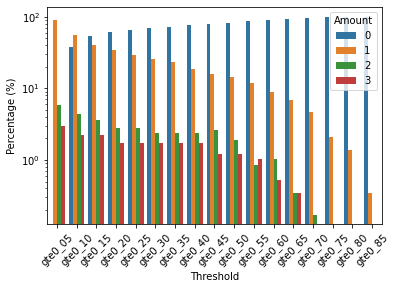

In [26]:
c = cat_counts_df.apply(lambda x: x*100/x.sum())
c['Amount'] = c.index
ax = sns.barplot(data=c.melt(id_vars='Amount', var_name='Threshold', value_name='Percentage (%)'), x='Threshold', y='Percentage (%)', hue='Amount')
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation=45)

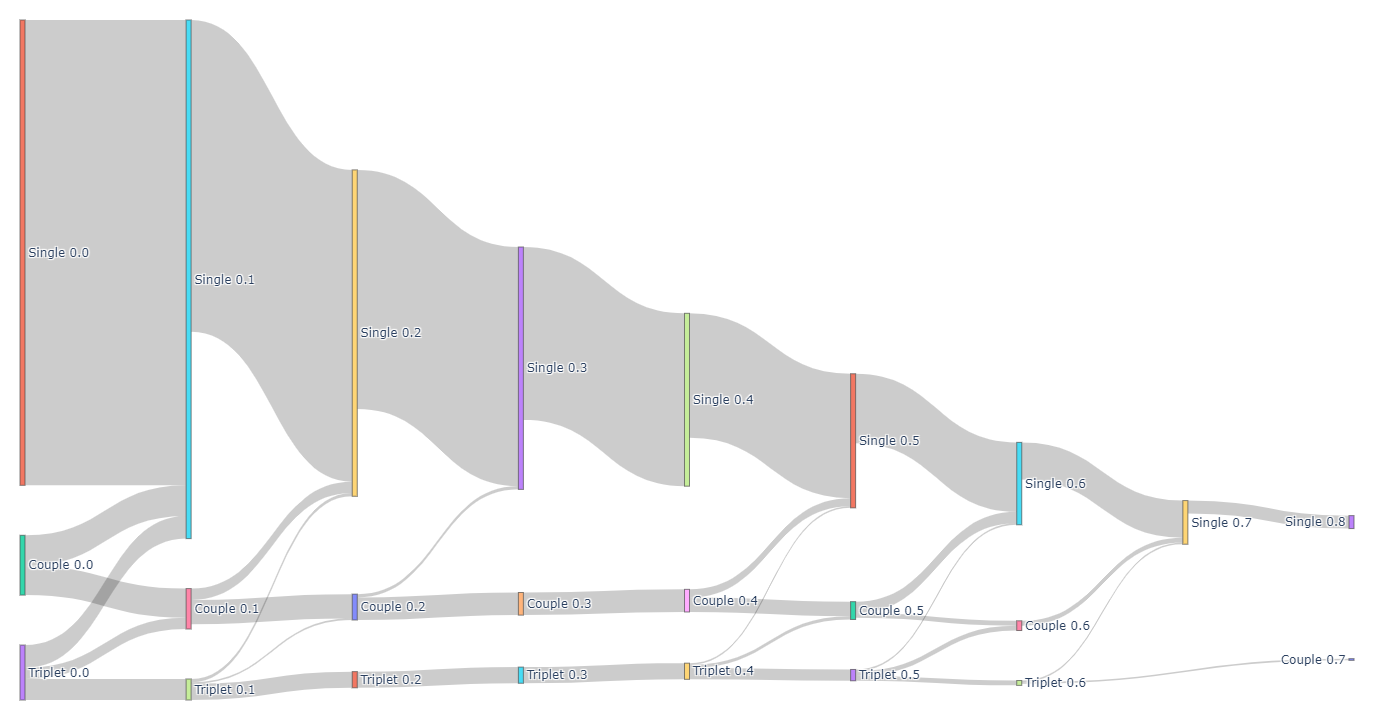

In [80]:
import plotly.graph_objects as go

for i in range(counts_df.shape[1]):
    counts_df.iloc[:, i] += i*4

links = []
for i in range(len(t_range)-1):
    g = counts_df.groupby([f'gte{t_range[i]:.1f}'.replace('.','_'), f'gte{t_range[i+1]:.1f}'.replace('.','_')])

    compound_dict = [(orig, fin, vals.shape[0]) for (orig, fin), vals in g if fin%4]
#     amount = sum(s for (_, _, s) in compound_dict)
#     compound_dict = [(orig, fin, a/amount) for (orig, fin, a) in compound_dict]
    links.extend(compound_dict)

node_values = pd.Series(counts_df.to_numpy().reshape(-1)).value_counts().sort_index()
counts_df = counts_df % 4

# data
source, target, value = zip(*links)
label = [f'{n} {t:.1f}' if t==0 or t>=0.1 else f'{n} {t:.3f}' for t in t_range for n in ['No hit', 'Single', 'Couple', 'Triplet']]

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad=50, thickness=5)
data = go.Sankey(link = link, node=node)
# plot
fig = go.Figure(data)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
#     height=250,
#     paper_bgcolor="LightSteelBlue",
)
fig.write_html("/home/naorko/file.html")
fig.show()

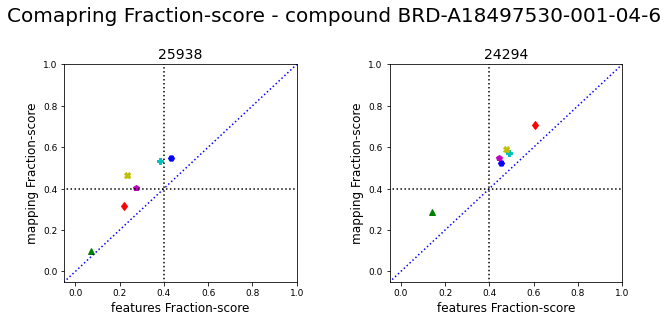

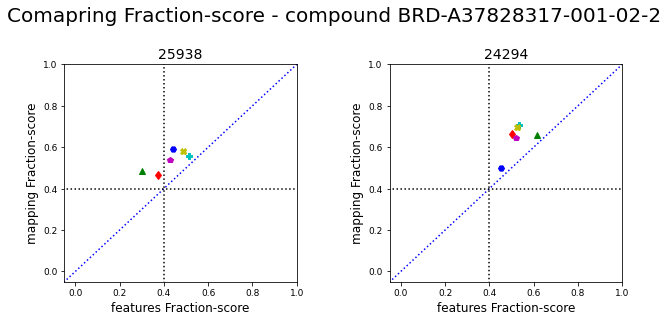

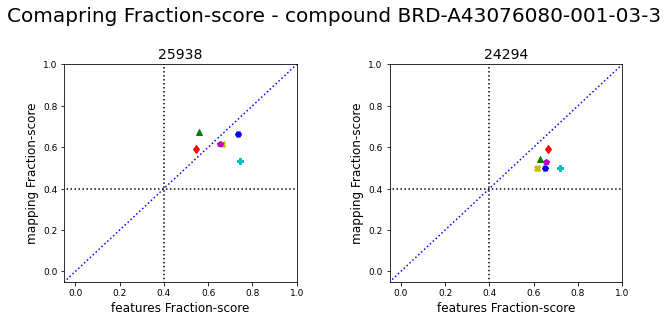

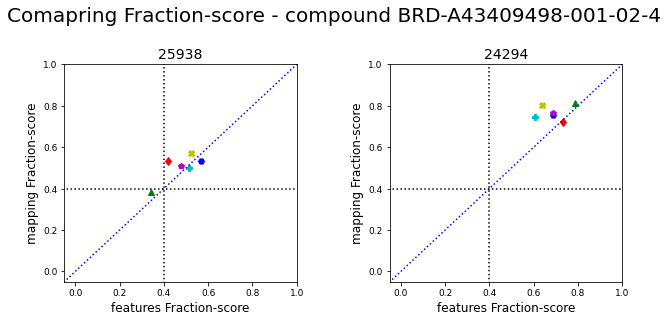

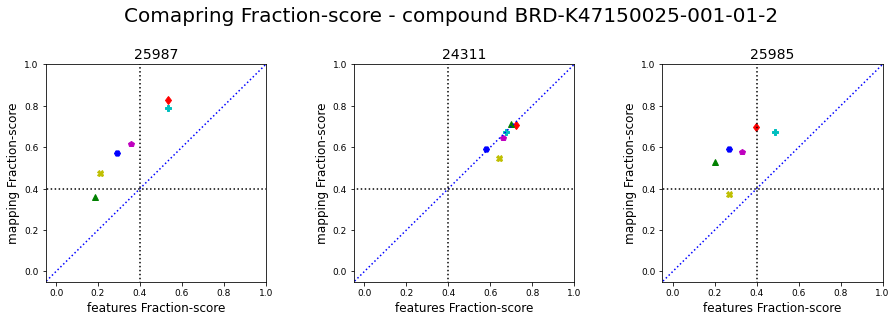

In [92]:
# compare_path = f'{plots_path}/compare'
# makedirs(compare_path, exist_ok=True)
filter_hit = 0.4

markers = ['d', '^', 'H', 'P', 'X','p']
colors = ['r', 'g', 'b', 'c', 'y', 'm']
d={'xlabel':"features Fraction-score", 'ylabel':"mapping Fraction-score"}

compounds_names = counts_df[counts_df[f'gte{filter_hit:.1f}'.replace('.', '_')] > 1].sample(5).index
for compound in compounds_names:
    curr_df = joined[joined.index.get_level_values(1) == compound]

    
    ncols = curr_df.shape[0]
    fig, ax = plt.subplots(ncols=ncols, figsize=(ncols*5, 4), sharey=True, sharex=True, subplot_kw=d, facecolor='white')
    fig.subplots_adjust(hspace=1, wspace=0.4)
    fig.suptitle(f'Comapring Fraction-score - compound {compound}', fontsize = 20, y=1.08)
    
    symbols = [0,0,0,0,0,0]
    for i, (index, row) in enumerate(curr_df.iterrows()):
        for j, chan in enumerate(CHANNELS):
            symbols[j] = ax[i].plot(row[chan+"_raw"], row[chan+"_map"], f'{colors[j]}{markers[j]}')[0]
            
        symbols[-1] = ax[i].plot(row['ALL_raw'], row["ALL_map"], f'{colors[-1]}{markers[-1]}')[0]


        ax[i].plot(range(-10, 150),range(-10, 150), 'b:')
        ax[i].plot(range(-10, 150),[0.4]*160, 'k:')
        ax[i].plot([0.4]*160,range(-10, 150), 'k:')
#         ax[i].set(xlim=(0, 50), ylim=(0, 50))
        ax[i].set(xlim=(-0.05, 1), ylim=(-0.05, 1))
#         ax[i].set_yscale('symlog')
#         ax[i].set_xscale('symlog')
        ax[i].set_title(f'{index[0]}')
        ax[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                         bottom=True, top=False, left=True, right=False)
        ax[i].tick_params(axis='both', labelsize = 9)
        ax[i].yaxis.label.set_size(12)
        ax[i].xaxis.label.set_size(12)
        ax[i].title.set_size(14)
    

#     fig.legend(symbols, CHANNELS+["ALL"], markerscale=1.2, fontsize='x-large', bbox_to_anchor=(1.05,1))
#     fig.savefig(f'{compare_path}/{compound}.eps', format='eps')

plt.show()

In [7]:
cols = CHANNELS + ['ALL']

def calculate_center(row, raw):
    map_vals = [row[f'{col}_map'] for col in cols]
    raw_vals = [row[f'{col}_{raw}'] for col in cols]
    
    return np.mean(raw_vals), np.mean(map_vals)

def calculate_euclidian_distance(pnt1, pnt2):
    x1, y1 = pnt1
    x2, y2 = pnt2
    
    return np.sqrt(np.power(x1-x2, 2) + np.power(y1-y2, 2))

def calculate_cosine_similarity(pnt1, pnt2):
    return np.dot(pnt1, pnt2) / ( (np.dot(pnt1, pnt1) **.5) * (np.dot(pnt2, pnt2) ** .5) )

def calculate_metrics(compound1, compound2, verbose=0, raw_model=False):
    raw = 'raw1to1' if raw_model else 'raw'
    idx1, row1 = compound1
    idx2, row2 = compound2
    
#     print(f'Compare between: {idx1} <--> {idx2}')
#     return {}

    center1 = calculate_center(row1, raw)
    center2 = calculate_center(row2, raw)
    if verbose:
        print(f'Center of row1: {center1[0]:.2f},{center1[1]:.2f}')
        print(f'Center of row2: {center2[0]:.2f},{center2[1]:.2f}')

#     center_dist = calculate_euclidian_distance(center1, center2)
#     if verbose:
#         print(f'Centers distance: {center_dist:.4f}')

    center_dlt = center1[0]-center2[0], center1[1]-center2[1]
    if verbose:
        print(f'Centers delta: {center_dlt[0]:.4f},{center_dlt[1]:.4f}')

#     mean_dist_x = sum(np.abs(row1[f'{col}_{raw}'] - row2[f'{col}_{raw}']) for col in cols)/len(cols)
#     mean_dist_y = sum(np.abs(row1[f'{col}_map'] - row2[f'{col}_map']) for col in cols)/len(cols)
#     mean_sum_dist = sum(calculate_euclidian_distance(
#         (row1[f'{col}_{raw}'], row1[f'{col}_map']),
#         (row2[f'{col}_{raw}'], row2[f'{col}_map']))
#         for col in cols)/len(cols)

    mean_dist_x_shift = sum(np.abs(row1[f'{col}_{raw}'] - (row2[f'{col}_{raw}'] + center_dlt[0])) for col in cols)/len(cols)
    mean_dist_y_shift = sum(np.abs(row1[f'{col}_map'] - (row2[f'{col}_map'] + center_dlt[1])) for col in cols)/len(cols)
#     mean_sum_dist_shift = sum(calculate_euclidian_distance(
#         (row1[f'{col}_{raw}'], row1[f'{col}_map']),
#         (row2[f'{col}_{raw}'] + center_dlt[0], row2[f'{col}_map'] + center_dlt[1]))
#         for col in cols)/len(cols)


#     cos_dist_by_center = sum(1-calculate_cosine_similarity(
#         (row1[f'{col}_{raw}'] - center1[0], row1[f'{col}_map'] - center1[1]),
#         (row2[f'{col}_{raw}'] - center2[0], row2[f'{col}_map'] - center2[1]))
#         for col in cols)/len(cols)

    if verbose:
        print(f'Summation Distance of points with Shift: {sum_dist_shift:.4f}')
        print(f'Summation Distance of points: {sum_dist:.4f}')
        print(f'Mean-Summation Distance of points with Shift: {mean_sum_dist_shift:.4f}')
        print(f'Mean-Summation Distance of points: {mean_sum_dist:.4f}')
        print(f'Cosine Similarity by Center of points: {cos_dist_by_center:.4f}')
        print()

#     cols_dists = {}
#     for col in cols:
#         cols_dists = {**cols_dists, **{
#             f'{col}': calculate_euclidian_distance(
#                 (row1[f'{col}_{raw}'], row1[f'{col}_map']),
#                 (row2[f'{col}_{raw}'], row2[f'{col}_map'])),
#             f'{col} X': np.abs(
#                 row1[f'{col}_{raw}'] - row2[f'{col}_{raw}']),
#             f'{col} Y': np.abs(
#                 row1[f'{col}_map'] - row2[f'{col}_map']),

#             f'{col} with Shift': calculate_euclidian_distance(
#                 (row1[f'{col}_{raw}'], row1[f'{col}_map']),
#                 (row2[f'{col}_{raw}'] + center_dlt[0], row2[f'{col}_map'] + center_dlt[1])),
#             f'{col} X with Shift': np.abs(
#                 row1[f'{col}_{raw}'] - (row2[f'{col}_{raw}'] + center_dlt[0])),
#             f'{col} Y with Shift': np.abs(
#                 row1[f'{col}_map'] - (row2[f'{col}_map'] + center_dlt[1]))
#         }}
            
    return {
#             'Center 1 - X' : center1[0],
#             'Center 1 - Y' : center1[1],
#             'Center 2 - X' : center2[0],
#             'Center 2 - Y' : center2[1],
#         'Center Distance' : center_dist,
        'Center Delta X': np.abs(center_dlt[0]),
        'Center Delta Y': np.abs(center_dlt[1]),
#         'Mean-Sum Distance': mean_sum_dist,
#         'Mean-Sum Distance X': mean_dist_x,
#         'Mean-Sum Distance Y': mean_dist_y,
#         'Mean-Sum Distance with Shift': mean_sum_dist_shift,
        'Mean-Sum Distance X with Shift': mean_dist_x_shift,
        'Mean-Sum Distance Y with Shift': mean_dist_y_shift,
#         **cols_dists,
#         'Cosine Similarity by Center': cos_dist_by_center,
    }
    

from itertools import combinations, islice
def compare_compounds_pairs(df, verbose=0, raw_model=False, cap=10000):
    compound_gen = islice(combinations(df.iterrows(), 2), cap)
    cs1, cs2 = zip(*compound_gen)
    
    p = Pool(8)
    
    compares = p.starmap(calculate_metrics, zip(cs1, cs2, cycle([verbose]), cycle([raw_model])))
                              
    p.close()
    p.join()
    
    return compares

def compare_compounds_one2many(c_data, df, verbose=0, raw_model=False, cap=10000):
    p, c, w = c_data.name
    compound_gen = islice(zip(cycle([(c_data.name, c_data)]), df.query(f'Plate != {p}').iterrows()), cap)
    cs1, cs2 = zip(*compound_gen)
    
    p = Pool(8)
    
    compares = p.starmap(calculate_metrics, zip(cs1, cs2, cycle([verbose]), cycle([raw_model])))
                              
    p.close()
    p.join()
    
    return compares

In [8]:
c = joined.query('Metadata_broad_sample == "BRD-A26222320-001-02-6"')
c

,,,AGP_map,DNA_map,ER_map,Mito_map,RNA_map,ALL_map,AGP_raw,DNA_raw,ER_raw,Mito_raw,RNA_raw,ALL_raw,AGP_raw1to1,DNA_raw1to1,ER_raw1to1,Mito_raw1to1,RNA_raw1to1,ALL_raw1to1
Plate,Metadata_broad_sample,Image_Metadata_Well,,,,,,,,,,,,,,,,,,
24294,BRD-A26222320-001-02-6,i24,0.779070,0.857143,0.779070,0.802326,0.837209,0.809179,0.662791,0.600000,0.534884,0.616279,0.581395,0.599034,0.360465,0.157143,0.302326,0.395349,0.313953,0.311594
25938,BRD-A26222320-001-02-6,i24,0.593023,0.600000,0.639535,0.627907,0.593023,0.611111,0.546512,0.542857,0.709302,0.686047,0.639535,0.628019,0.465116,0.328571,0.476744,0.511628,0.406977,0.442029


In [9]:
compare_compounds_pairs(c)

[{'Center Delta X': 0.026314860288571107,
  'Center Delta Y': 0.19989942275078765,
  'Mean-Sum Distance X with Shift': 0.07535054916248042,
  'Mean-Sum Distance Y with Shift': 0.033843352717636464}]

In [10]:
compare_compounds_pairs(c, raw_model=True)

[{'Center Delta X': 0.13170590784342046,
  'Center Delta Y': 0.19989942275078765,
  'Mean-Sum Distance X with Shift': 0.027478453464297736,
  'Mean-Sum Distance Y with Shift': 0.033843352717636464}]

In [11]:
def extract_compares_only_multiple(filter_hit=0.4, raw_model=False):
    compounds_names = list(counts_df.query(f'gte0_00 > 1 and gte{filter_hit:.2f} > 0'.replace('.','_')).index)
    df_to_pair = joined[joined.index.isin(compounds_names, 1)]
    groupby_compound = df_to_pair.groupby('Metadata_broad_sample')
    
    vals_per_compounds = groupby_compound.apply(compare_compounds_pairs, raw_model=raw_model).values
    compares_dup = np.concatenate(vals_per_compounds)
    print(f'Total of {len(compares_dup)} compares with duplicate compounds')

    compares_dup = {k: [dic[k] for dic in compares_dup] for k in compares_dup[0]}
    compares_dup = pd.DataFrame(compares_dup)
    compares_dup['Type'] = 'Same'

    vals_per_compounds = [np.concatenate(g.apply(compare_compounds_one2many, axis=1, df=df_to_pair.query(f'Metadata_broad_sample != "{c}"'), raw_model=raw_model).values) 
                          for c, g in groupby_compound]
    compares_sing = np.concatenate(vals_per_compounds)
    print(f'Total of {len(compares_sing)} compares with unique compounds')

    compares_sing = {k: [dic[k] for dic in compares_sing] for k in compares_sing[0]}
    compares_sing = pd.DataFrame(compares_sing)
    compares_sing['Type'] = 'Different'
    
    return pd.concat([compares_sing, compares_dup])

In [105]:
def extract_compares(filter_hit=0.4, raw_model=False):
    compounds_names = list(counts_df.query(f'gte0_00 > 1 and gte{filter_hit:.2f} > 0'.replace('.','_')).index)
    df_to_pair = joined[joined.index.isin(compounds_names, 1)]
    vals_per_compounds = df_to_pair.groupby('Metadata_broad_sample').apply(compare_compounds_pairs, raw_model=raw_model).values
    compares_dup = np.concatenate(vals_per_compounds)
    print(f'Total of {len(compares_dup)} compares with duplicate compounds')

    compares_dup = {k: [dic[k] for dic in compares_dup] for k in compares_dup[0]}
    compares_dup = pd.DataFrame(compares_dup)
    compares_dup['Type'] = 'Same'

    compounds_names = list(counts_df.query(f'gte0_00 == 1 and gte{filter_hit:.2f} == 1'.replace('.','_')).index)
    df_to_pair = joined[joined.index.isin(compounds_names, 1)].query(f'ALL_map > {filter_hit}')
    compares_sing = compare_compounds_pairs(df_to_pair, raw_model=raw_model)
    print(f'Total of {len(compares_sing)} compares with unique compounds')

    compares_sing = {k: [dic[k] for dic in compares_sing] for k in compares_sing[0]}
    compares_sing = pd.DataFrame(compares_sing)
    compares_sing['Type'] = 'Different'

    return pd.concat([compares_sing, compares_dup])

In [13]:
def compare_compounds(filter_hit=0.4):
# compares_raw = extract_compares(raw_model=False)
# compares_raw1to1 = extract_compares(raw_model=True)
    compares_raw = extract_compares_only_multiple(filter_hit=filter_hit, raw_model=False)
    compares_raw1to1 = extract_compares_only_multiple(filter_hit=filter_hit, raw_model=True)

    compares_raw['Type'] = compares_raw['Type'] + '_raw'
    compares_raw1to1['Type'] = compares_raw1to1['Type'] + '_raw1to1'

    return pd.concat([compares_raw,compares_raw1to1])

compares = []
for t in t_range[1:]:
    print(f'Processing threshold {t:.2f}')
    df_t = compare_compounds(t)
    df_t['Threshold'] = f'{t:.2f}'
    compares.append(df_t)

compares = pd.concat(compares)
compares_melt = compares.melt(id_vars=['Threshold','Type'],var_name='Metric')

Processing threshold 0.05
Total of 214 compares with duplicate compounds
Total of 71476 compares with unique compounds
Total of 214 compares with duplicate compounds
Total of 71476 compares with unique compounds
Processing threshold 0.10
Total of 139 compares with duplicate compounds
Total of 26116 compares with unique compounds
Total of 139 compares with duplicate compounds
Total of 26116 compares with unique compounds
Processing threshold 0.15
Total of 108 compares with duplicate compounds
Total of 14244 compares with unique compounds
Total of 108 compares with duplicate compounds
Total of 14244 compares with unique compounds
Processing threshold 0.20
Total of 95 compares with duplicate compounds
Total of 9952 compares with unique compounds
Total of 95 compares with duplicate compounds
Total of 9952 compares with unique compounds
Processing threshold 0.25
Total of 76 compares with duplicate compounds
Total of 6768 compares with unique compounds
Total of 76 compares with duplicate com

In [30]:
amount = compares[['Threshold', 'Type']].query('Type == "Different_raw" or Type == "Same_raw"').copy()
amount.loc[amount['Type'] == 'Different_raw', 'Type'] = 'Different'
amount.loc[amount['Type'] == 'Same_raw', 'Type'] = 'Same'
amount = amount.value_counts().sort_index()
amount[amount.index.isin(['Different'],1)] /=2
amount

Threshold  Type     
0.05       Different    35738
           Same           214
0.10       Different    13058
           Same           139
0.15       Different     7122
           Same           108
0.20       Different     4976
           Same            95
0.25       Different     3384
           Same            76
0.30       Different     2852
           Same            71
0.35       Different     2300
           Same            62
0.40       Different     2300
           Same            62
0.45       Different     1542
           Same            49
0.50       Different     1542
           Same            49
0.55       Different     1104
           Same            43
0.60       Different      902
           Same            39
0.65       Different      306
           Same            25
0.70       Different      114
           Same            15
0.75       Different       14
           Same             5
0.80       Different        6
           Same             4
dtype: int64

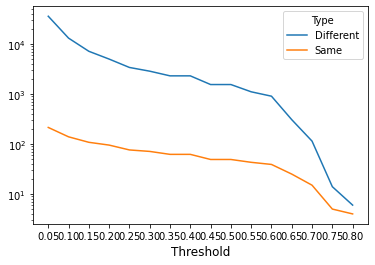

In [56]:
ax = sns.lineplot(data=amount, hue='Type', x='Threshold', y=amount)
ax.set_yscale('log')

In [14]:
compares_algo = compares.copy()
compares_algo['Algo'] = compares_algo['Type'].str.split('_').apply(lambda x: x[1])
compares_algo['Type'] = compares_algo['Type'].str.split('_').apply(lambda x: x[0])
compares_algo

,Center Delta X,Center Delta Y,Mean-Sum Distance X with Shift,Mean-Sum Distance Y with Shift,Type,Threshold,Algo
0,0.581668,0.838753,0.070602,0.016729,Different,0.05,raw
1,0.051935,0.037892,0.043297,0.026381,Different,0.05,raw
2,0.166814,0.046368,0.045367,0.027922,Different,0.05,raw
3,0.117471,0.035108,0.093329,0.031232,Different,0.05,raw
4,0.214511,0.085146,0.049209,0.044615,Different,0.05,raw
...,...,...,...,...,...,...,...
11,0.061866,0.038652,0.036150,0.053707,Different,0.80,raw1to1
0,0.131706,0.199899,0.027478,0.033843,Same,0.80,raw1to1
1,0.138410,0.193195,0.040446,0.059132,Same,0.80,raw1to1
2,0.052253,0.272205,0.035344,0.066554,Same,0.80,raw1to1


In [142]:
g = compares_algo.groupby(['Threshold', 'Algo'])

delta_mean = g.apply(lambda x: x.query('Type == "Different"').drop(['Type','Threshold','Algo'],axis=1).mean() - x.query('Type == "Same"').drop(['Type','Threshold','Algo'],axis=1).mean())
delta_median = g.apply(lambda x: x.query('Type == "Different"').drop(['Type','Threshold','Algo'],axis=1).median() - x.query('Type == "Same"').drop(['Type','Threshold','Algo'],axis=1).median())

delta_mean = delta_mean.reset_index().melt(id_vars=['Threshold','Algo'],var_name='Metric')
delta_median = delta_median.reset_index().melt(id_vars=['Threshold','Algo'],var_name='Metric')

In [143]:
color_map = {t: f'C{i}' for i, t in enumerate(['Different_raw', 'Same_raw', 'Different_raw1to1', 'Same_raw1to1'])}
color_map2 = {t: f'C{i}' for i, t in enumerate(['raw', 'raw1to1'])}
def draw_hist(data, **kws):
    ax = sns.kdeplot('value', data=data)
    t = data['Type'].iloc[0]
    color=color_map[t]
    
    x = ax.get_lines()[-1].get_xdata()
    y = ax.get_lines()[-1].get_ydata()
    max_id = np.argmax(y)
    
    ax.plot(x[max_id], y[max_id], '.', color=color, markersize=12)
    plt.axvline(data['value'].median(), color=color, linestyle='--')


def draw_pointplot(data, **kws):
    t = data['Type'].iloc[0]
    color=color_map[t]
    
    sns.pointplot(data=data,
                  x='Threshold',
                  y='value',
                 color=color,
                 capsize=.2,)

def draw_line(data, **kws):
    t = data['Algo'].iloc[0]
    color=color_map2[t]
    
    plt.plot(data['Threshold'], data['value'], color=color)
    plt.axhline(0, color='k', linestyle='--')

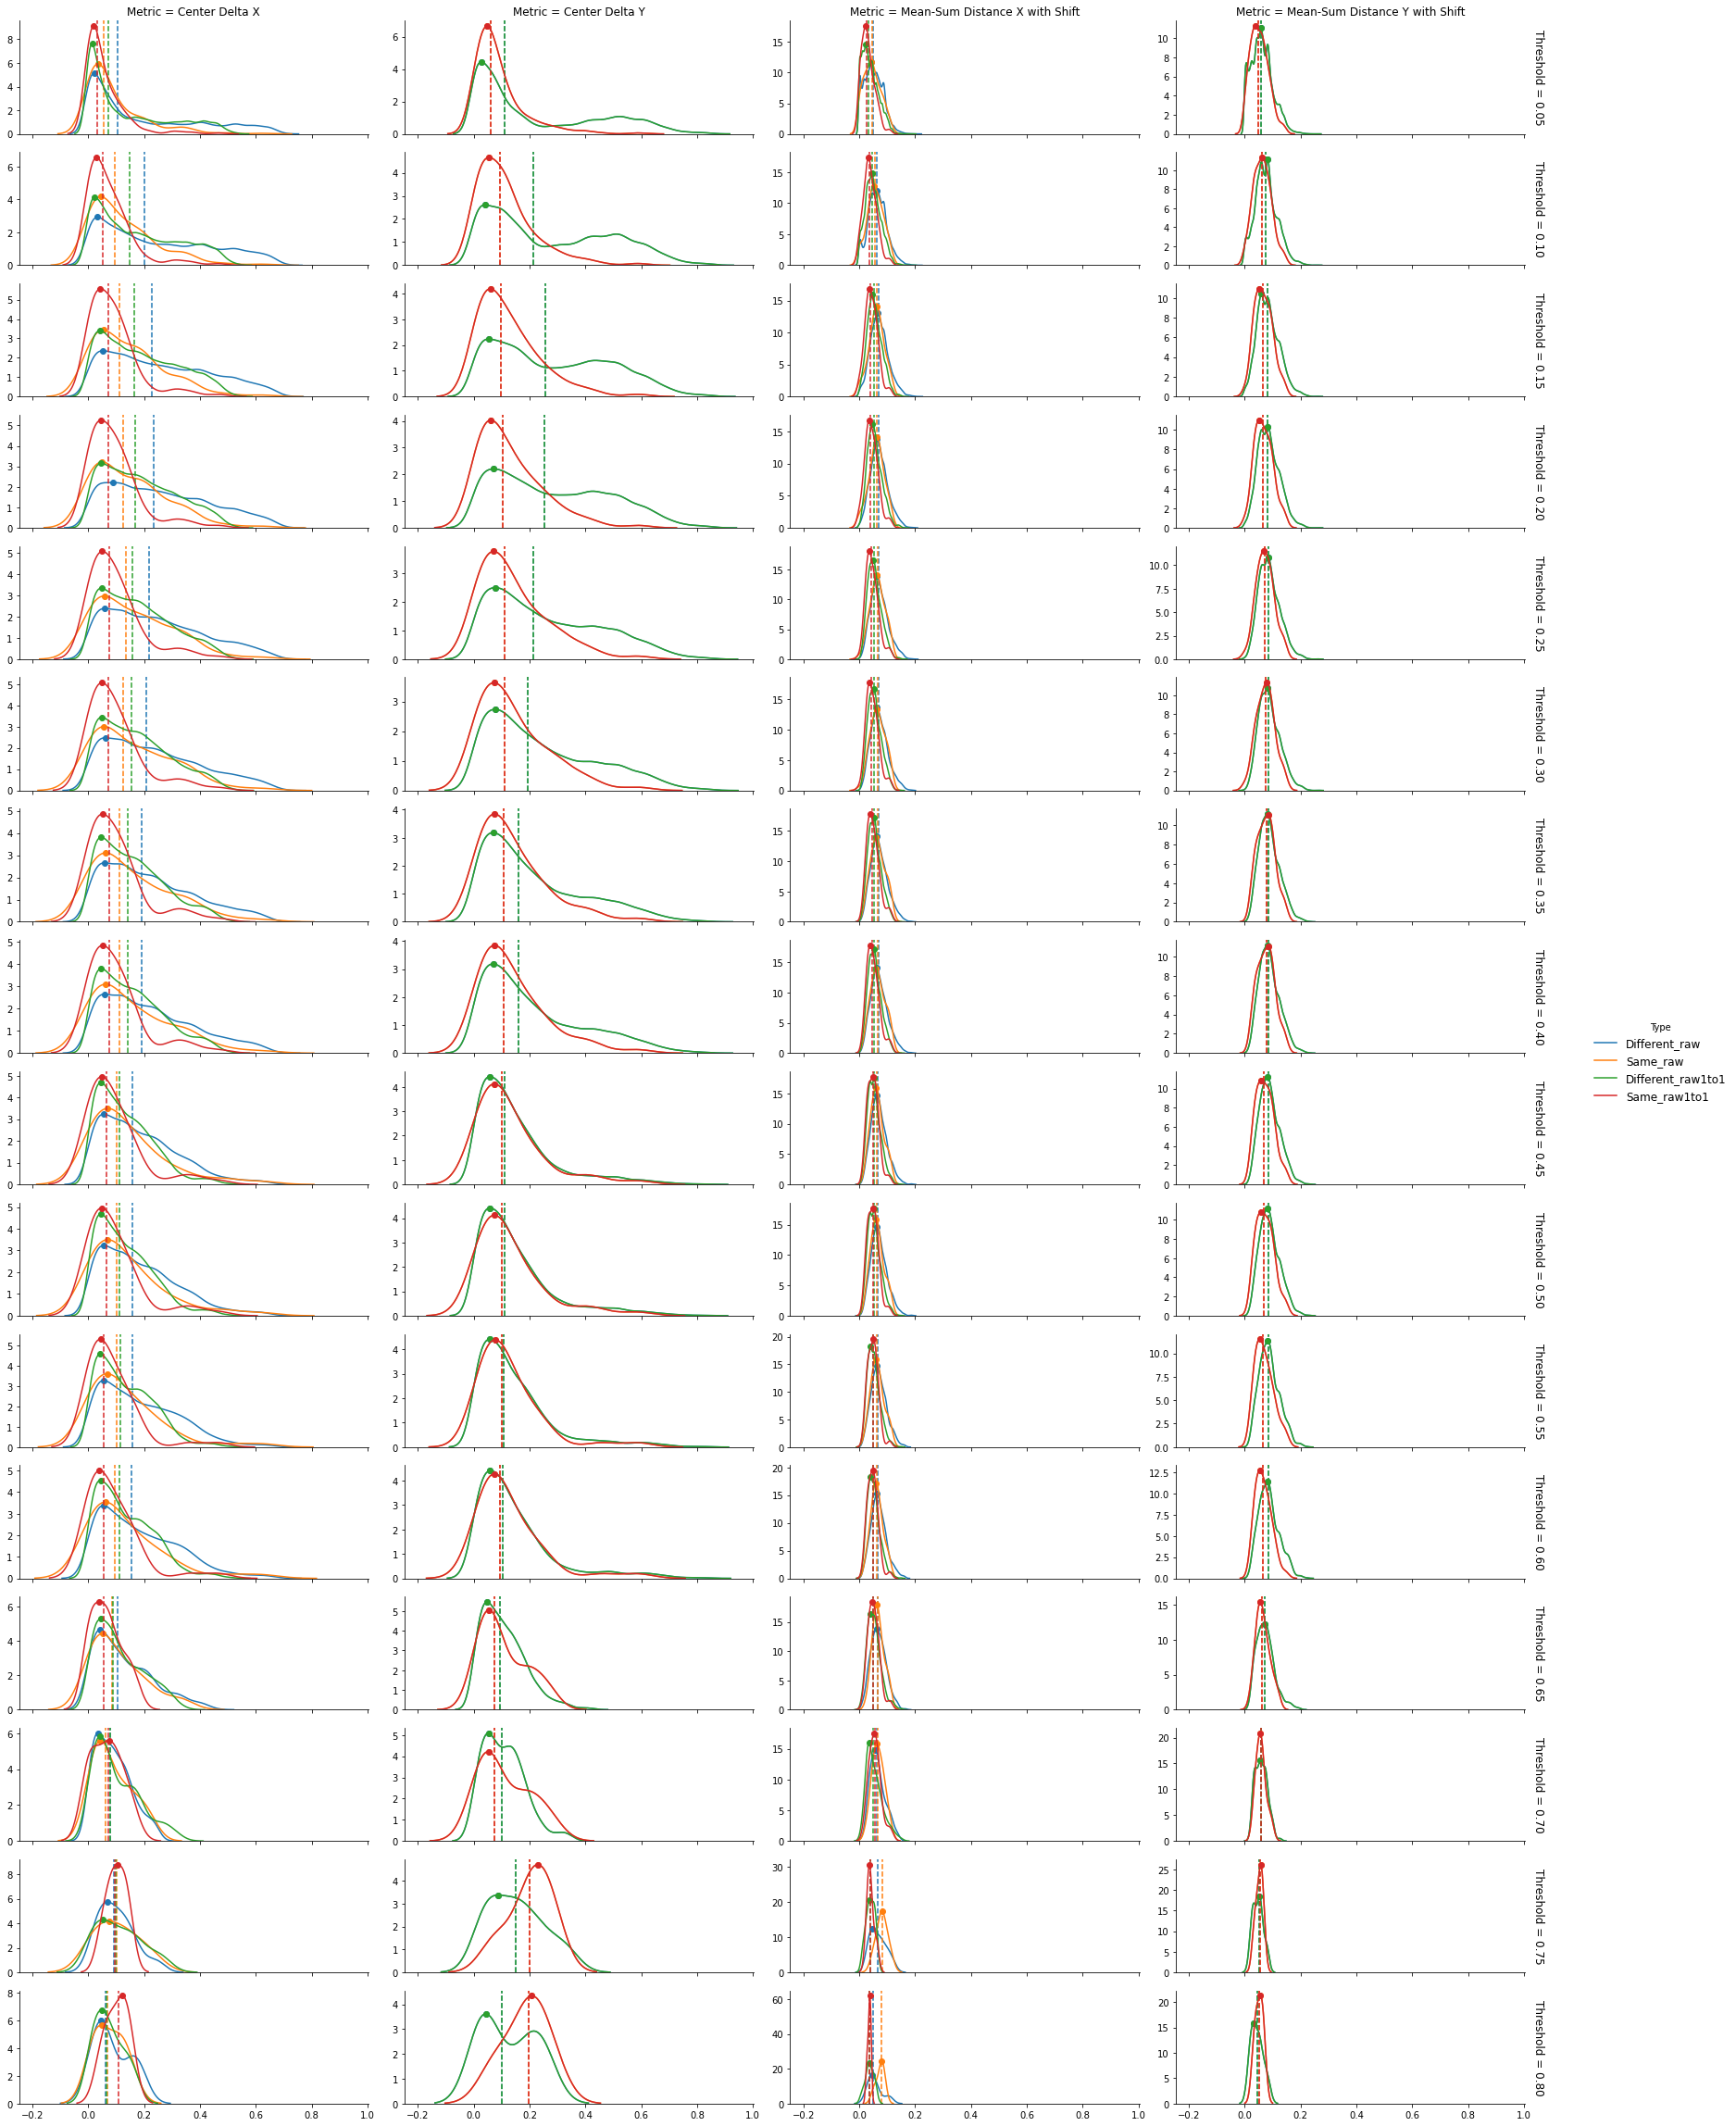

In [27]:
plt.rcParams.update({'axes.labelsize': 'large'})
ts = compares_melt['Threshold'].unique()
ts.sort()
g = sns.FacetGrid(compares_melt, col='Metric', hue='Type', row='Threshold', row_order=ts, #col_wrap=2,, 
                  margin_titles=True, height=2, aspect=3,
#                   subplot_kws = {}, gridspec_kws={'facecolor': 'white'},
                  sharex=True, sharey=False)
# _ = g.map(sns.kdeplot, 'value', fill=True)

g = g.map_dataframe(draw_hist)
_ = g.add_legend({lbl: lne for lbl, lne in 
                  zip(['Different_raw', 'Same_raw', 'Different_raw1to1', 'Same_raw1to1'],
                      [l for i, l in enumerate(g.axes[0,0].get_lines()) if not i % 3])}, fontsize=12, title_fontsize=14)

In [44]:
compares_melt.loc[compares_melt.query('Metric == "Center Delta X" or Metric == "Center Delta Y"').index, 'Measure'] = 'Hit Reproduction'
compares_melt.loc[compares_melt.query('Metric != "Center Delta X" and Metric != "Center Delta Y"').index, 'Measure'] = 'Specifity'

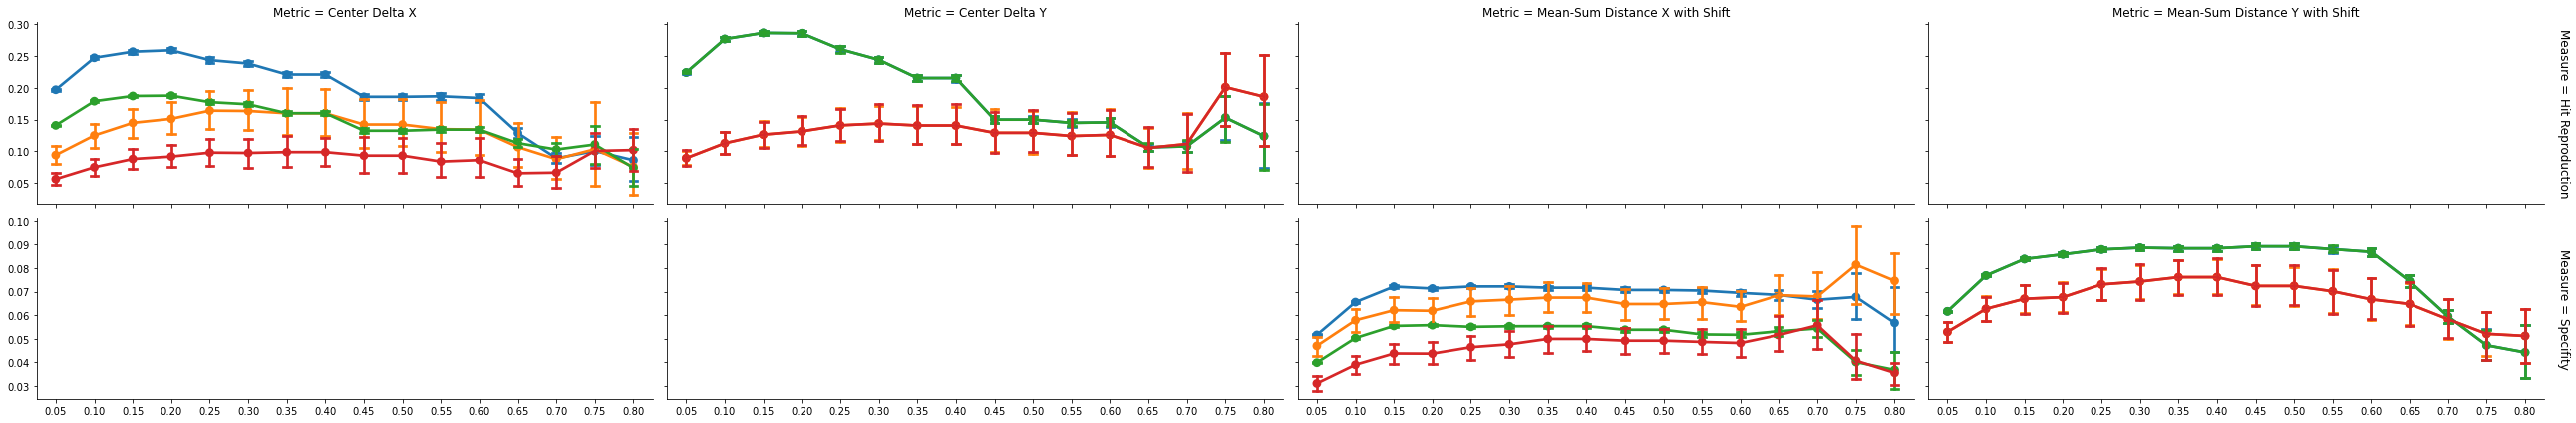

In [47]:
plt.rcParams.update({'axes.labelsize': 'large'})
ts = compares_melt['Threshold'].unique()
ts.sort()
g = sns.FacetGrid(compares_melt, col='Metric', hue='Type',  row='Measure',#col_wrap=2,#, row='Threshold'row_order=ts,
                  margin_titles=True, height=3, aspect=3,
#                   subplot_kws = {}, gridspec_kws={'facecolor': 'white'},
                  sharex=True, sharey='row')
# _ = g.map(sns.kdeplot, 'value', fill=True)

g = g.map_dataframe(draw_pointplot)
# _ = g.add_legend({lbl: lne for lbl, lne in 
#                   zip(['Different_raw', 'Same_raw', 'Different_raw1to1', 'Same_raw1to1'],
#                       [l for i, l in enumerate(g.axes[0].get_lines()) if not i % (len(g.axes[0].get_lines())/4)])}, fontsize=12, title_fontsize=14)

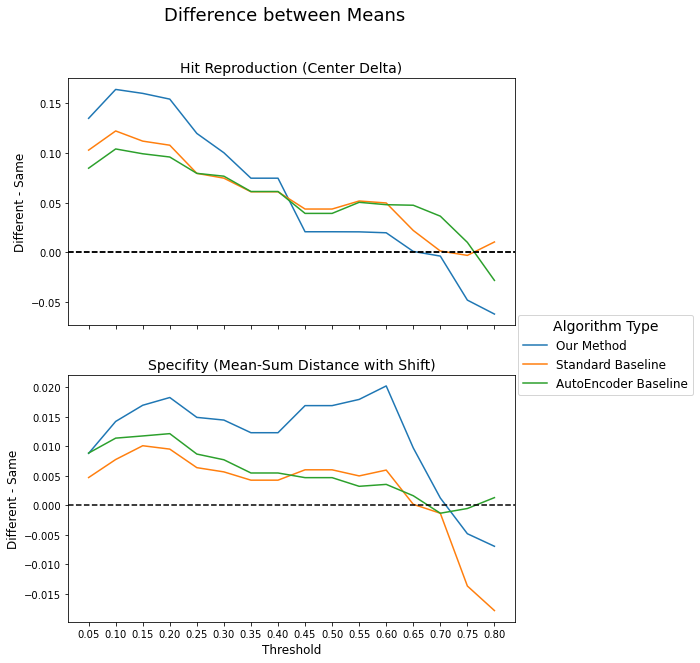

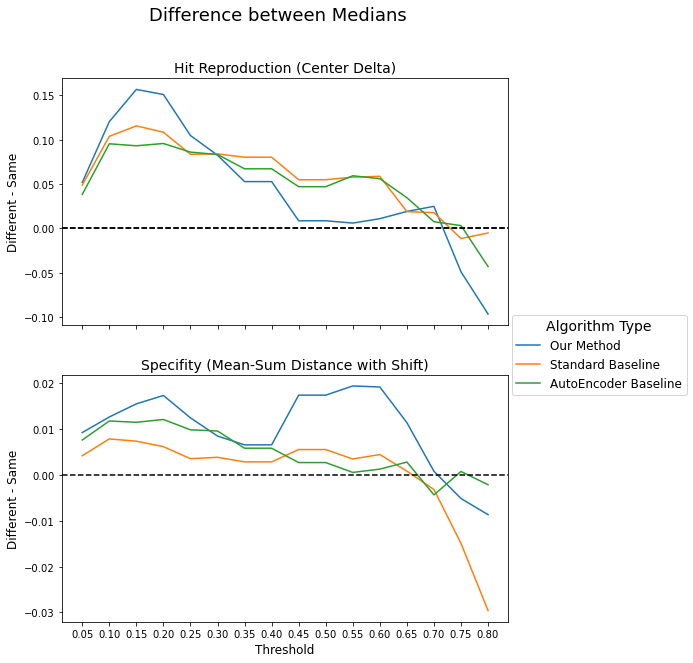

In [144]:
for name, deltas in zip([f'Difference between {n}'for n in ['Means', 'Medians']], [delta_mean, delta_median]):
    fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8, 10))
    fig.suptitle(name, fontsize=18)

    lines = [None]*3


    df = deltas.query('Algo == "raw" and Metric == "Center Delta Y"')
    lines[0], = ax[0].plot(df['Threshold'], df['value'])
    df = deltas.query('Algo == "raw" and Metric == "Center Delta X"')
    lines[1], = ax[0].plot(df['Threshold'], df['value'])
    df = deltas.query('Algo == "raw1to1" and Metric == "Center Delta X"')
    lines[2], = ax[0].plot(df['Threshold'], df['value'])
    ax[0].set_title('Hit Reproduction (Center Delta)', fontsize=14)
    ax[0].axhline(0, color='k', linestyle='--')

    
    df = deltas.query('Algo == "raw" and Metric == "Mean-Sum Distance Y with Shift"')
    _ = ax[1].plot(df['Threshold'], df['value'])
    df = deltas.query('Algo == "raw" and Metric == "Mean-Sum Distance X with Shift"')
    _ = ax[1].plot(df['Threshold'], df['value'])
    df = deltas.query('Algo == "raw1to1" and Metric == "Mean-Sum Distance X with Shift"')
    _ = ax[1].plot(df['Threshold'], df['value'])
    ax[1].set_title('Specifity (Mean-Sum Distance with Shift)', fontsize=14)

    for i in range(2):
        ax[i].axhline(0, color='k', linestyle='--')
        ax[i].set_ylabel('Different - Same', fontsize=12)
    ax[1].set_xlabel('Threshold', fontsize=12)

    _ = fig.legend(lines, ['Our Method', 'Standard Baseline', 'AutoEncoder Baseline'],
                   bbox_to_anchor=(1.22,0.56), title='Algorithm Type', fontsize=12, title_fontsize=14)



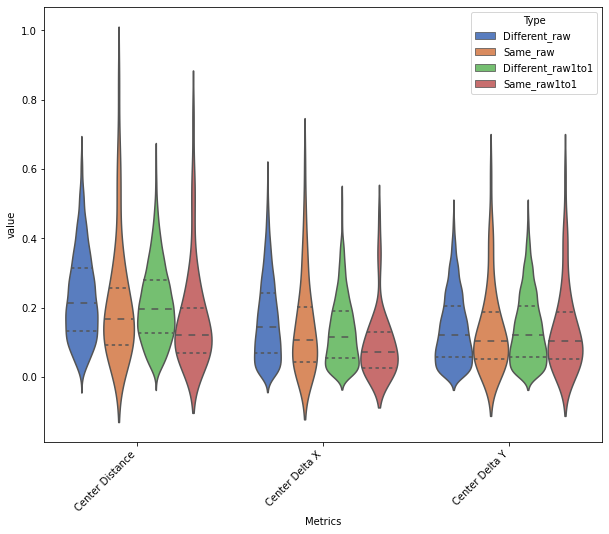

In [143]:
fig, ax = plt.subplots(figsize=(10,8), facecolor='#ffffff')
sns.violinplot(x="Metrics", y="value", hue="Type",
                    data=compares, palette="muted",  inner="quartile", ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

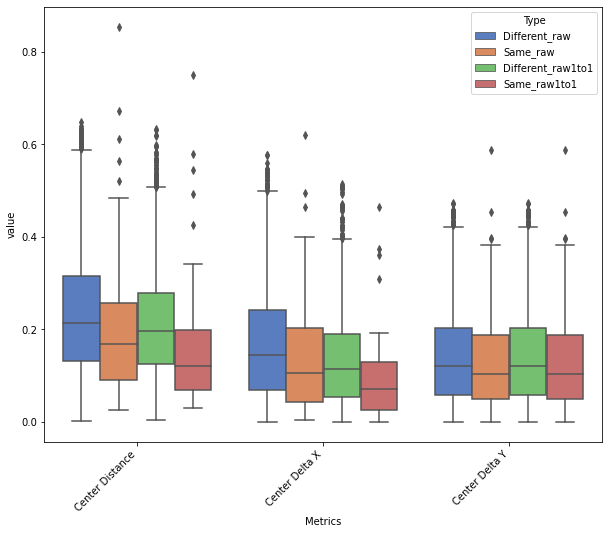

In [144]:
fig, ax = plt.subplots(figsize=(10,8), facecolor='#ffffff')
sns.boxplot(x="Metrics", y="value", hue="Type",
                    data=compares, palette="muted", ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [27]:
compares.groupby(['Metrics','Type']).describe()

value            \
                                                          count      mean   
Metrics                                       Type                          
Center Delta X                                Different  9591.0  0.179817   
                                              Same         62.0  0.157389   
Center Delta Y                                Different  9591.0  0.172707   
                                              Same         62.0  0.142950   
Center Distance                               Different  9591.0  0.267182   
                                              Same         62.0  0.224306   
Mean-Summation Distance Pairwise              Different  9591.0  0.316050   
                                              Same         62.0  0.251041   
Mean-Summation Distance Pairwise with Shift   Different  9591.0  0.154364   
                                              Same         62.0  0.106913   
Mean-Summation Distance X Pairwise            Different  9591.0  0.210670   
                                              Same         62.0  0.173166   
Mean-Summation Distance X Pairwise with Shift Different  9591.0  0.102743   
                                              Same         62.0  0.067152   
Mean-Summation Distance Y Pairwise            Different  9591.0  0.205711   
                                              Same         62.0  0.163428   
Mean-Summation Distance Y Pairwise with Shift Different  9591.0  0.100243   
                                              Same         62.0  0.074102   

                                                                             \
                                                              std       min   
Metrics                                       Type                            
Center Delta X                                Different  0.128773  0.000000   
                                              Same       0.138312  0.001012   
Center Delta Y                                Different  0.126609  0.000000   
                                              Same       0.126248  0.001012   
Center Distance                               Different  0.152928  0.002660   
                                              Same       0.172853  0.026317   
Mean-Summation Distance Pairwise              Different  0.131214  0.046599   
                                              Same       0.160596  0.059790   
Mean-Summation Distance Pairwise with Shift   Different  0.055753  0.026916   
                                              Same       0.035901  0.039334   
Mean-Summation Distance X Pairwise            Different  0.109998  0.008557   
                                              Same       0.127585  0.026925   
Mean-Summation Distance X Pairwise with Shift Different  0.044988  0.004214   
                                              Same       0.025169  0.023555   
Mean-Summation Distance Y Pairwise            Different  0.105715  0.011628   
                                              Same       0.113733  0.007908   
Mean-Summation Distance Y Pairwise with Shift Different  0.042976  0.008603   
                                              Same       0.031038  0.008128   

                                                                             \
                                                              25%       50%   
Metrics                                       Type                            
Center Delta X                                Different  0.074455  0.157829   
                                              Same       0.045134  0.111907   
Center Delta Y                                Different  0.064967  0.150873   
                                              Same       0.050689  0.108207   
Center Distance                               Different  0.149050  0.244995   
                                              Same       0.089110  0.175708   
Mean-Summation Distance Pairwise              Different  0.220632  0.

## P-value, Wilcoxon rank sum

In [22]:
compares_algo

,Center Delta X,Center Delta Y,Mean-Sum Distance X with Shift,Mean-Sum Distance Y with Shift,Type,Threshold,Algo
0,0.581668,0.838753,0.070602,0.016729,Different,0.05,raw
1,0.051935,0.037892,0.043297,0.026381,Different,0.05,raw
2,0.166814,0.046368,0.045367,0.027922,Different,0.05,raw
3,0.117471,0.035108,0.093329,0.031232,Different,0.05,raw
4,0.214511,0.085146,0.049209,0.044615,Different,0.05,raw
...,...,...,...,...,...,...,...
11,0.061866,0.038652,0.036150,0.053707,Different,0.80,raw1to1
0,0.131706,0.199899,0.027478,0.033843,Same,0.80,raw1to1
1,0.138410,0.193195,0.040446,0.059132,Same,0.80,raw1to1
2,0.052253,0.272205,0.035344,0.066554,Same,0.80,raw1to1


In [40]:
from scipy.stats import ranksums

In [152]:
def extract_pvals(df):
    def extract_pval(dff, field):
        _, pval = ranksums(dff.query('Type == "Different"')[field], dff.query('Type == "Same"')[field], alternative='greater')
        return pval
    
    center_raw = extract_pval(df.query('Algo == "raw"'), 'Center Delta X')
    return pd.DataFrame({
        'Hit Reproduction': [extract_pval(df.query('Algo == "raw"'), 'Center Delta Y'), *[extract_pval(df.query(f'Algo == "{t}"'), 'Center Delta X') for t in ['raw', 'raw1to1']]],
        'Specifity': [extract_pval(df.query('Algo == "raw"'), 'Mean-Sum Distance Y with Shift'), *[extract_pval(df.query(f'Algo == "{t}"'), 'Mean-Sum Distance X with Shift') for t in ['raw', 'raw1to1']]],
        'Type': ['map', 'raw', 'raw1to1']
    }).set_index('Type')
    

In [153]:
pvals = compares_algo.groupby('Threshold').apply(extract_pvals)
pvals

Hit Reproduction     Specifity
Threshold Type                                   
0.05      map          3.867076e-13  1.164938e-03
          raw          3.734869e-11  3.156365e-02
          raw1to1      1.430050e-14  1.511886e-05
0.10      map          2.315468e-18  1.556011e-05
          raw          9.954442e-14  6.677245e-03
          raw1to1      1.293107e-18  8.883481e-07
0.15      map          1.529687e-16  7.546097e-06
          raw          3.281112e-11  2.573092e-03
          raw1to1      3.539266e-16  1.968964e-06
0.20      map          1.512909e-14  3.363815e-06
          raw          5.314177e-10  6.801789e-03
          raw1to1      5.451685e-15  3.828650e-06
0.25      map          2.955148e-08  6.993366e-04
          raw          1.595643e-05  8.593533e-02
          raw1to1      5.198222e-10  6.646494e-04
0.30      map          5.269653e-06  2.355658e-03
          raw          5.945723e-05  1.233120e-01
          raw1to1      3.245015e-09  2.135391e-03
0.35      map          9.677951e-04  8.350906e-03
          raw          6.646891e-04  1.970347e-01
          raw1to1      1.151370e-06  2.178121e-02
0.40      map          9.677951e-04  8.350906e-03
          raw          6.646891e-04  1.970347e-01
          raw1to1      1.151370e-06  2.178121e-02
0.45      map          1.560211e-01  7.353661e-04
          raw          4.035827e-03  8.516125e-02
          raw1to1      1.933074e-04  9.161161e-02
0.50      map          1.560211e-01  7.353661e-04
          raw          4.035827e-03  8.516125e-02
          raw1to1      1.933074e-04  9.161161e-02
0.55      map          2.161974e-01  5.126487e-04
          raw          2.793639e-03  1.410654e-01
          raw1to1      3.625322e-05  2.346120e-01
0.60      map          2.534693e-01  2.207723e-04
          raw          4.702533e-03  1.067695e-01
          raw1to1      1.486570e-04  2.048286e-01
0.65      map          4.226415e-01  8.667030e-02
          raw          1.445797e-01  5.511690e-01
          raw1to1      2.404497e-03  4.435715e-01
0.70      map          5.257005e-01  4.878991e-01
          raw          4.367284e-01  6.943241e-01
          raw1to1      4.188584e-02  7.549553e-01
0.75      map          9.041303e-01  8.169423e-01
          raw          4.204124e-01  9.041303e-01
          raw1to1      5.399943e-01  5.399943e-01
0.80      map          8.873735e-01  7.665729e-01
          raw          3.138129e-01  9.552225e-01
          raw1to1      8.340123e-01  5.000000e-01

In [154]:
pvals_melt = pvals.reset_index().melt(id_vars=['Threshold','Type'],var_name='Metric')
pvals_melt

,Threshold,Type,Metric,value
0,0.05,map,Hit Reproduction,3.867076e-13
1,0.05,raw,Hit Reproduction,3.734869e-11
2,0.05,raw1to1,Hit Reproduction,1.430050e-14
3,0.10,map,Hit Reproduction,2.315468e-18
4,0.10,raw,Hit Reproduction,9.954442e-14
...,...,...,...,...
91,0.75,raw,Specifity,9.041303e-01
92,0.75,raw1to1,Specifity,5.399943e-01
93,0.80,map,Specifity,7.665729e-01
94,0.80,raw,Specifity,9.552225e-01


In [157]:
def draw_line2(data, **kws):
    plt.plot(data['Threshold'], data['value'])#, color=color)
    plt.axhline(0, color='k', linestyle='--')
#     plt.yscale('log')

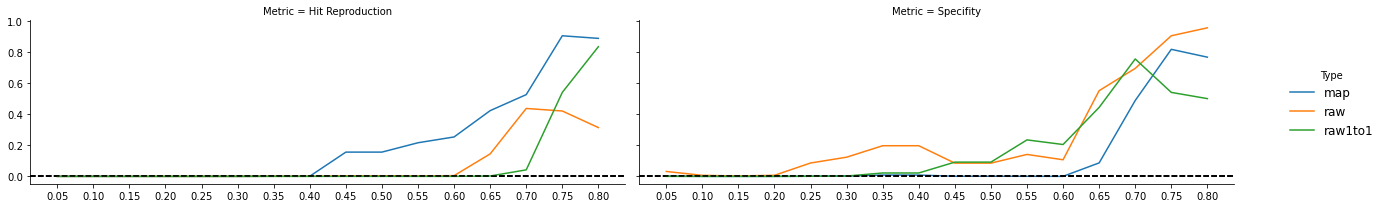

In [159]:
g = sns.FacetGrid(pvals_melt, col='Metric', hue='Type',
                  margin_titles=True, height=3, aspect=3,
#                   subplot_kws = {}, gridspec_kws={'facecolor': 'white'},
                  sharex=True, sharey='row')

g = g.map_dataframe(draw_line2)

_ = g.add_legend({lbl: lne for lbl, lne in 
                  zip(['map', 'raw', 'raw1to1'],
                      [l for i, l in enumerate(g.axes[0,0].get_lines()) if not i % 2])}, fontsize=12, title_fontsize=14)